In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
!bash install_mecab-ko_on_colab_light_220429.sh

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk import FreqDist
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# from konlpy.tag import Mecab
import plotly.express as px

In [4]:
total=pd.read_csv('/content/drive/MyDrive/올리브영 리뷰 크롤링/oliveyoung_review(20230502).csv')

In [5]:
total=total[~total['review_text'].isnull()]

# 전처리

In [ ]:
ad=total[total['review_date'].str.contains('체험단')]
non_ad=total[~total['review_date'].str.contains('체험단')]

In [ ]:
ad_group=ad.groupby('product_name').count()[['review_text']]
non_ad_group=non_ad.groupby('product_name').count()[['review_text']]

ad_group.reset_index(inplace=True)
non_ad_group.reset_index(inplace=True)

In [ ]:
def remove_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  removed_df = df[(df[column] >= lowest) & (df[column] <= highest) ]
  return removed_df

In [ ]:
ad_group=remove_outlier(df=ad_group, column='review_text', weight=1.5)
non_ad_group=remove_outlier(df=non_ad_group, column='review_text', weight=1.5)

In [ ]:
target_product=pd.merge(ad_group, non_ad_group, how='inner', on='product_name')
target_product=list(target_product['product_name'])

In [ ]:
ad_review=ad[ad['product_name'].isin(target_product)]
non_ad_review=non_ad[non_ad['product_name'].isin(target_product)]
ad_review.reset_index(inplace=True, drop=True)
non_ad_review.reset_index(inplace=True, drop=True)

# 단어 수 카운트

In [ ]:
tokenizer = Mecab()

In [ ]:
# 전처리
ad_review['review_text'] = ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
non_ad_review['review_text'] = non_ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")

<ipython-input-17-7c823162e1b5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ad_review['review_text'] = ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
<ipython-input-17-7c823162e1b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_review['review_text'] = ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
<ipython-input-17-7c823162e1b5>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  non_ad_review['review_text'] = non_ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
<ipython-input-17-7c823162e1b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
stopwords=pd.read_excel('/content/drive/MyDrive/불용어.xlsx', header=None)

In [ ]:
stopwords=list(stopwords[0])

In [ ]:
ad_review_word_cnt=[]
for sentence in tqdm(ad_review['review_text']):
  temp = tokenizer.morphs(sentence) # 토큰화
  temp = [word for word in temp if not word in stopwords] # 불용어 제거
  ad_review_word_cnt.append([sentence, len(temp)])


100%|██████████| 27898/27898 [00:45<00:00, 610.35it/s]


In [ ]:
non_ad_review_word_cnt=[]
for sentence in tqdm(non_ad_review['review_text']):
  temp = tokenizer.morphs(sentence) # 토큰화
  temp = [word for word in temp if not word in stopwords] # 불용어 제거
  non_ad_review_word_cnt.append([sentence, len(temp)])


100%|██████████| 39089/39089 [00:30<00:00, 1269.90it/s]


In [ ]:
ad_token=pd.DataFrame(ad_review_word_cnt, columns=['review_text','token_cnt'])
non_ad_token=pd.DataFrame(non_ad_review_word_cnt, columns=['review_text','token_cnt'])

In [ ]:
ad_token['token_cnt'].mean()

140.18822137787654

In [ ]:
non_ad_token['token_cnt'].mean()

69.0587889175983

# 빈도수 비교

## 명사 워드클라우드

In [ ]:
tokenized_ad=[]
for sentence in tqdm(ad_review['review_text']):
    temp = tokenizer.pos(sentence) # 품사 태깅
    nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
    tokenized_ad.append(nouns)

100%|██████████| 27898/27898 [00:16<00:00, 1726.11it/s]


In [ ]:
tokenized_non_ad=[]
for sentence in tqdm(non_ad_review['review_text']):
    temp = tokenizer.pos(sentence) # 품사 태깅
    nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
    tokenized_non_ad.append(nouns)

100%|██████████| 39089/39089 [00:12<00:00, 3119.11it/s]


In [ ]:
len(tokenized_ad)

27898

In [ ]:
vocab_ad = FreqDist(np.hstack(tokenized_ad))
print('단어 집합의 크기 : {}'.format(len(vocab_ad)))

단어 집합의 크기 : 17435


In [ ]:
vocab_non_ad = FreqDist(np.hstack(tokenized_non_ad))
print('단어 집합의 크기 : {}'.format(len(vocab_non_ad)))

단어 집합의 크기 : 15225


In [ ]:
vocab_size = 100
# 상위 vocab_size개의 단어만 보존
vocab_ad = vocab_ad.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab_ad)))

단어 집합의 크기 : 100


In [ ]:
vocab_size = 100
# 상위 vocab_size개의 단어만 보존
vocab_non_ad = vocab_non_ad.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab_non_ad)))

단어 집합의 크기 : 100


In [ ]:
ad_data=dict(vocab_ad)
non_ad_data=dict(vocab_non_ad)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


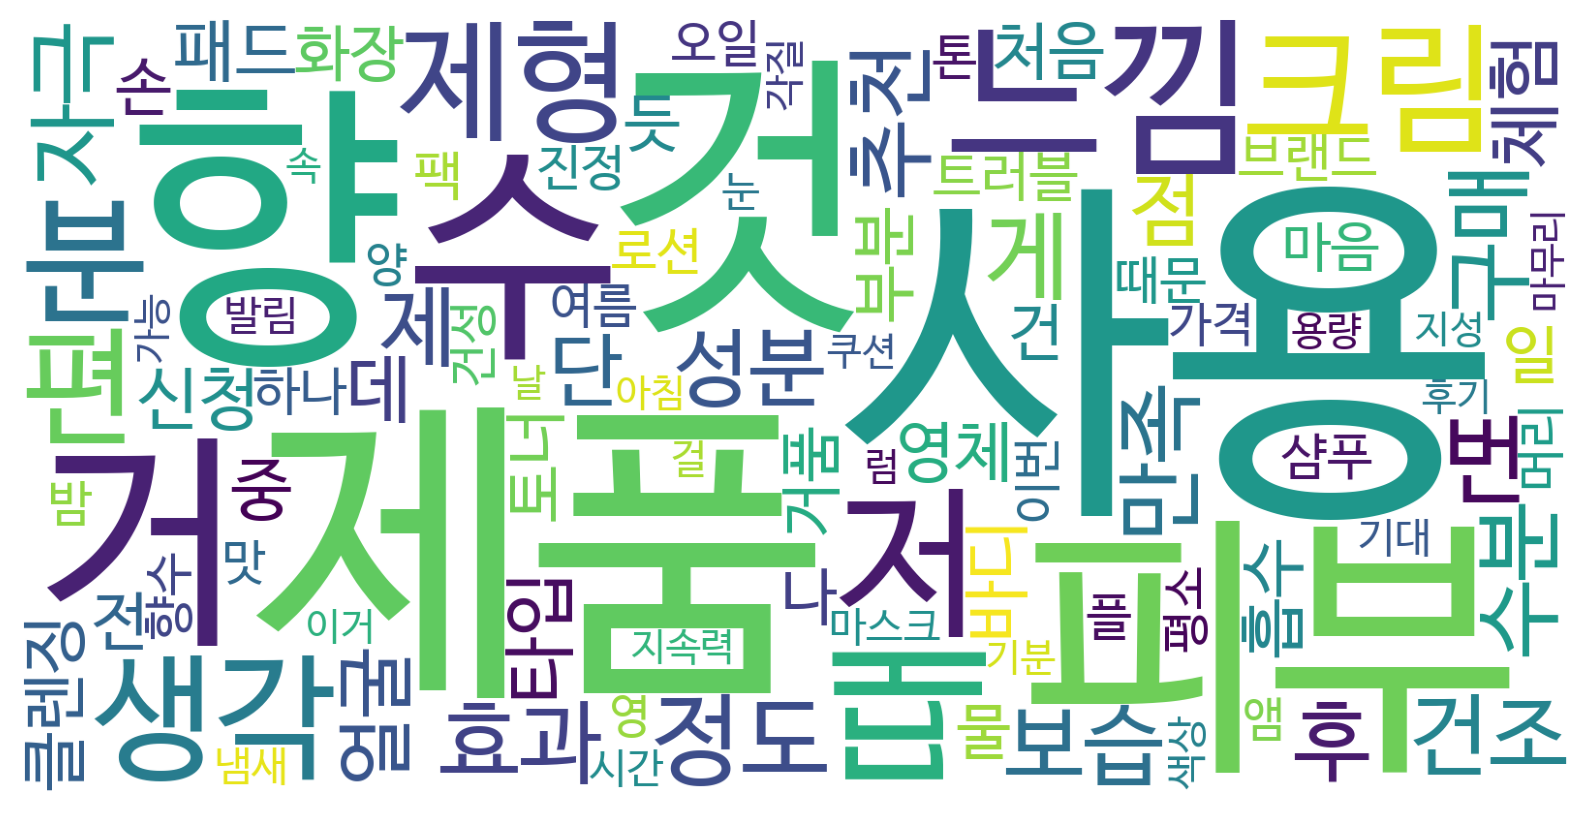

In [ ]:
wc = WordCloud(font_path=fontpath, #폰트
               background_color='white',                              #배경색
               width=1600, height=800)
#                max_words=200)                                         #단어갯수
cloud = wc.generate_from_frequencies(ad_data)                            #사전형태 데이터

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기

plt.imshow(cloud)

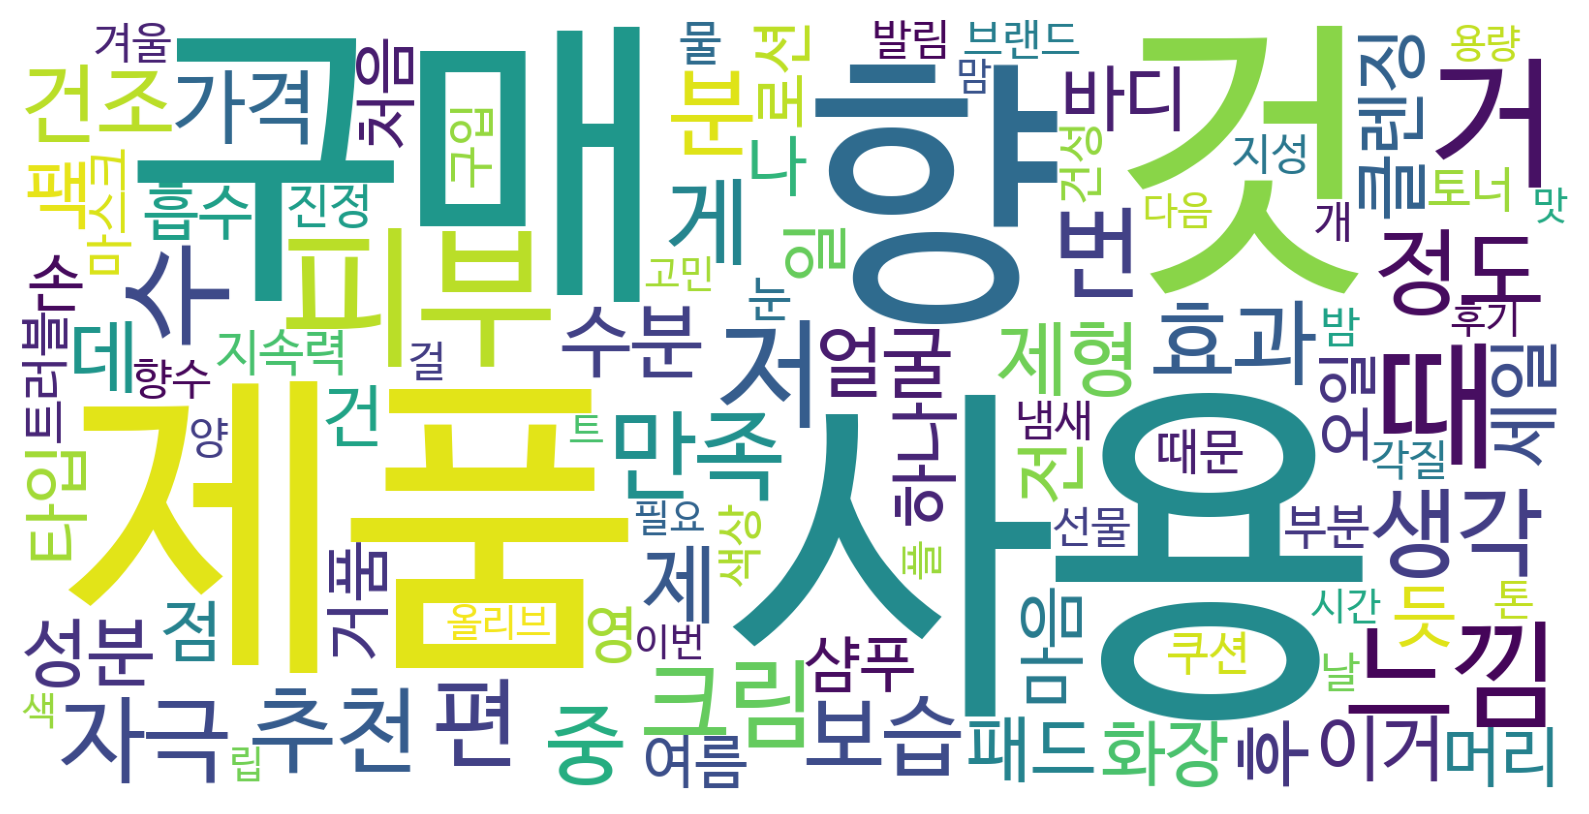

In [ ]:
wc = WordCloud(font_path=fontpath, #폰트
               background_color='white',                              #배경색
               width=1600, height=800)
#                max_words=200)                                         #단어갯수
cloud = wc.generate_from_frequencies(non_ad_data)                            #사전형태 데이터

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기

plt.imshow(cloud)

## 비교 표 생성

In [ ]:
ad_word=pd.DataFrame(vocab_ad, columns=['keyword', 'ad_cnt'])
non_ad_word=pd.DataFrame(vocab_non_ad, columns=['keyword', 'non_ad_cnt'])

In [ ]:
non_ad_word[non_ad_word['keyword']=='구매']

,keyword,non_ad_cnt
2,구매,21984


In [ ]:
ad_word[ad_word['keyword']=='구매']

,keyword,ad_cnt
22,구매,7588


In [ ]:
ad_word.reset_index(inplace=True)
non_ad_word.reset_index(inplace=True)
ad_word.rename(columns={'index':'ad_rank'}, inplace=True)
non_ad_word.rename(columns={'index':'non_ad_rank'}, inplace=True)

In [ ]:
ad_word['ad_rank']=ad_word['ad_rank'].astype(int)+1
non_ad_word['non_ad_rank']=non_ad_word['non_ad_rank'].astype(int)+1

In [ ]:
total_word=pd.merge(ad_word, non_ad_word, how='outer', on='keyword')

In [ ]:
total_word[total_word['ad_rank'].isnull()]

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt
100,NaN,세일,NaN,38.0,3528.0
101,NaN,구입,NaN,68.0,2444.0
102,NaN,선물,NaN,79.0,2172.0
103,NaN,개,NaN,81.0,2138.0
104,NaN,겨울,NaN,85.0,2069.0
105,NaN,올리브,NaN,88.0,2015.0
106,NaN,색,NaN,91.0,1986.0
107,NaN,고민,NaN,92.0,1951.0
108,NaN,다음,NaN,93.0,1919.0
109,NaN,맘,NaN,94.0,1908.0


In [ ]:
total_word[total_word['non_ad_rank'].isnull()]

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt
29,30.0,단,6833.0,NaN,NaN
32,33.0,체험,5686.0,NaN,NaN
35,36.0,신청,5412.0,NaN,NaN
41,42.0,영체,4962.0,NaN,NaN
72,73.0,평소,3580.0,NaN,NaN
75,76.0,앰,3445.0,NaN,NaN
80,81.0,기대,3207.0,NaN,NaN
88,89.0,럼,3000.0,NaN,NaN
89,90.0,마무리,2994.0,NaN,NaN
91,92.0,기분,2977.0,NaN,NaN


## 연산

In [ ]:
total_word2=pd.merge(ad_word, non_ad_word, how='inner', on='keyword')
total_word2['ad_rank-non_ad_rank']=total_word2['ad_rank']-total_word2['non_ad_rank']

In [ ]:
total_word2.sort_values(by='ad_rank-non_ad_rank').head(5)

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt,ad_rank-non_ad_rank
66,71,맛,3625,98,1879,-27
38,43,부분,4806,65,2545,-22
61,66,밤,3774,87,2025,-21
41,46,토너,4666,64,2649,-18
49,54,물,4335,72,2282,-18


In [ ]:
total_word2.sort_values(by='ad_rank-non_ad_rank', ascending=False).head(10)

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt,ad_rank-non_ad_rank
84,95,이거,2882,36,3586,59
69,75,가격,3447,27,4500,48
80,88,지속력,3017,60,2784,28
83,94,쿠션,2908,70,2308,24
51,56,팩,4270,34,3797,22
22,23,구매,7588,3,21984,20
71,78,영,3318,58,2823,20
65,70,머리,3711,50,2975,20
54,59,하나,4168,42,3313,17
72,79,마스크,3291,63,2681,16


## 글자 수 세기

In [ ]:
len_ad_text=[]
for sentence in tqdm(ad_review['review_text']):
  len_ad_text.append([sentence, len(sentence)])

100%|██████████| 27898/27898 [00:00<00:00, 120634.25it/s]


In [ ]:
len_non_ad_text=[]
for sentence in tqdm(non_ad_review['review_text']):
  len_non_ad_text.append([sentence, len(sentence)])

100%|██████████| 39089/39089 [00:00<00:00, 1187139.94it/s]


In [ ]:
len_ad_df=pd.DataFrame(len_ad_text, columns=['review_text', 'text_cnt'])
len_non_ad_df=pd.DataFrame(len_non_ad_text, columns=['review_text', 'text_cnt'])

In [ ]:
len_ad_df['text_cnt'].mean()

382.9289196358162

In [ ]:
len_non_ad_df['text_cnt'].mean()

185.49384737394152

# 명사, 조사 추출

In [ ]:
ad_review_pos=[]
for sentence in tqdm(ad_review['review_text']):
  temp = tokenizer.pos(sentence) # 품사 태깅
  nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
  josas= [temp[0] for temp in temp if temp[1].startswith('J')] #조사 추출
  ad_review_pos.append([sentence, len(temp), len(nouns), len(josas)])

100%|██████████| 27898/27898 [00:50<00:00, 549.73it/s]


In [ ]:
non_ad_review_pos=[]
for sentence in tqdm(non_ad_review['review_text']):
  temp = tokenizer.pos(sentence) # 품사 태깅
  nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
  josas= [temp[0] for temp in temp if temp[1].startswith('J')] #조사 추출
  non_ad_review_pos.append([sentence, len(temp),len(nouns), len(josas)])

100%|██████████| 39089/39089 [00:30<00:00, 1290.20it/s]


In [ ]:
ad_pos=pd.DataFrame(ad_review_pos, columns=['review_text','morphs_cnt','noun_cnt', 'josa_cnt'])
non_ad_pos=pd.DataFrame(non_ad_review_pos, columns=['review_text', 'morphs_cnt','noun_cnt', 'josa_cnt'])

ad_pos['josa_percentage']=round(ad_pos['josa_cnt']/ad_pos['morphs_cnt'],2)
non_ad_pos['josa_percentage']=round(non_ad_pos['josa_cnt']/non_ad_pos['morphs_cnt'], 2)

ad_pos['noun_percentage']=round(ad_pos['noun_cnt']/ad_pos['morphs_cnt'],2)
non_ad_pos['noun_percentage']=round(non_ad_pos['noun_cnt']/non_ad_pos['morphs_cnt'], 2)

ad_pos['noun/josa_percentage']=round(ad_pos['noun_percentage']/ad_pos['josa_percentage'],2)
non_ad_pos['noun/josa_percentage']=round(non_ad_pos['noun_percentage']/non_ad_pos['josa_percentage'], 2)

ad_pos=ad_pos[~((ad_pos['noun/josa_percentage']==np.inf)|(ad_pos['noun/josa_percentage'].isnull()))]
non_ad_pos=non_ad_pos[~((non_ad_pos['noun/josa_percentage']==np.inf)|(non_ad_pos['noun/josa_percentage'].isnull()))]

In [ ]:
print(ad_pos['noun/josa_percentage'].mean()), print(non_ad_pos['noun/josa_percentage'].mean())

2.41077201793722
2.719207519845527


(None, None)

In [ ]:
ad_pos['type']='ad'
non_ad_pos['type']='non_ad'
total_pos=pd.concat([ad_pos, non_ad_pos])
total_pos.reset_index(inplace=True, drop=True)

In [ ]:
fig = px.scatter(total_pos, x="josa_percentage", y="noun/josa_percentage", color="type")
fig.show()

# TF-IDF

In [6]:
total['review_point']=total['review_point'].apply(lambda x:str(x).split(' ')[1])

In [7]:
total_1=total[total['review_point']=='1점']
total_5=total[total['review_point']=='5점']

In [8]:
product_list_1=list(total_1.product_name.unique())
total_5=total_5[total_5['product_name'].isin(product_list_1)]

In [9]:
# 전처리
total_1['review_text'] = total_1['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
total_5['review_text'] = total_5['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")

<ipython-input-9-16dc5f28424e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  total_1['review_text'] = total_1['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
<ipython-input-9-16dc5f28424e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_1['review_text'] = total_1['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
<ipython-input-9-16dc5f28424e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  total_5['review_text'] = total_5['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")


In [93]:
review_1=list(total_1['review_text'])
review_5=list(total_5['review_text'])

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 각 그룹의 문서들을 리스트에 담기
group1_docs = review_1
group5_docs = review_5

# TfidfVectorizer 객체 생성 및 fit_transform 메소드를 사용하여 TF-IDF 값 계산
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(group1_docs + group5_docs)

# get_feature_names 메소드를 사용하여 단어 목록 추출
feature_names = vectorizer.get_feature_names_out()


In [139]:
# 상위 TF-IDF 값을 가지는 단어와 그 단어의 TF-IDF 값을 추출
topn = 100
group1_tfidf = tfidf[:len(group1_docs)]
group1_tfidf_sum = group1_tfidf.sum(axis=0)
group1_top_tfidf_idx = group1_tfidf_sum.argsort()[0, -topn:][::-1]
group1_top_tfidf_words = [feature_names[idx] for idx in group1_top_tfidf_idx]
group1_top_tfidf_values = [group1_tfidf_sum[0, idx] for idx in group1_top_tfidf_idx]
a = {'keyword' : list(group1_top_tfidf_words[0][0]), 'tfidf' : group1_top_tfidf_values[0].tolist()[0]}
group1_df=pd.DataFrame(a)

group5_tfidf = tfidf[len(group1_docs):]
group5_tfidf_sum = group5_tfidf.sum(axis=0)
group5_top_tfidf_idx = group5_tfidf_sum.argsort()[0, -topn:][::-1]
group5_top_tfidf_words = [feature_names[idx] for idx in group5_top_tfidf_idx]
group5_top_tfidf_values = [group5_tfidf_sum[0, idx] for idx in group5_top_tfidf_idx]
b = {'keyword' : list(group5_top_tfidf_words[0][0]), 'tfidf' : group5_top_tfidf_values[0].tolist()[0]}
group5_df=pd.DataFrame(b)


In [136]:
group1_df.sort_values(by='tfidf', ascending=False).head(10)

,keyword,tfidf
99,너무,203.963789
98,그냥,135.400719
97,진짜,115.300873
96,ㅠㅠ,109.124400
95,이거,90.485863
94,별로에요,68.803456
93,같아요,68.609098
92,정말,68.288098
91,샀는데,67.143747
90,저는,65.126684


In [137]:
group5_df.sort_values(by='tfidf', ascending=False).head(10)

,keyword,tfidf
99,좋아요,21215.104602
98,너무,16818.101100
97,같아요,11951.794045
96,진짜,9231.398411
95,좋고,7972.503924
94,많이,7852.784020
93,ㅎㅎ,7765.280611
92,정말,7663.251761
91,있어요,7442.250167
90,좋은,7139.100270


In [142]:
group1_df.reset_index(inplace=True)
group1_df.rename(columns={'index':'rank_1'}, inplace=True)
group5_df.reset_index(inplace=True)
group5_df.rename(columns={'index':'rank_5'}, inplace=True)

In [151]:
group1_df_only=pd.merge(group1_df, group5_df, how='left', on='keyword')
group1_df_only=group1_df_only[group1_df_only['rank_5'].isnull()]

In [152]:
group5_df_only=pd.merge(group5_df, group1_df, how='left', on='keyword')
group5_df_only=group5_df_only[group5_df_only['rank_1'].isnull()]

In [154]:
group1_df_only

,rank_1,keyword,tfidf_x,rank_5,tfidf_y
0,0,거의,22.408338,NaN,NaN
4,4,아쉽네요,22.665596,NaN,NaN
5,5,안되고,22.693335,NaN,NaN
7,7,나서,23.428196,NaN,NaN
8,8,아쉬워요,23.461560,NaN,NaN
9,9,제품이,23.577173,NaN,NaN
10,10,사봤는데,23.584094,NaN,NaN
11,11,별로입니다,23.595751,NaN,NaN
15,15,리뷰,24.173038,NaN,NaN
16,16,분들은,24.343208,NaN,NaN


In [153]:
group5_df_only

,rank_5,keyword,tfidf_x,rank_1,tfidf_y
0,0,추천합니다,2388.553004,NaN,NaN
1,1,무난하게,2395.297787,NaN,NaN
3,3,오래,2431.404242,NaN,NaN
8,8,맘에,2540.131367,NaN,NaN
9,9,사서,2551.021582,NaN,NaN
10,10,부드럽고,2594.732388,NaN,NaN
12,12,사용할,2670.896050,NaN,NaN
13,13,샀어요,2675.168163,NaN,NaN
14,14,있는데,2695.120315,NaN,NaN
16,16,살짝,2736.052353,NaN,NaN
